Predicting probabilities for labelling the multi-class-multi-label target variables using school data and thereby reducing the time for manually labelling the data henceforth

Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
%matplotlib inline

Data importing and analysing

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/train.csv')
df.head()

,Unnamed: 0,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
0,134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
1,206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
2,326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
3,364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
4,47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [ ]:
df.drop(labels='Unnamed: 0', inplace=True, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4              

In [ ]:
df.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


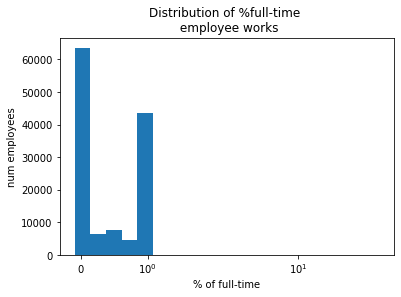

In [ ]:
plt.hist(df['FTE'].dropna(), bins=200)
plt.xscale(value='symlog')
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
plt.show()

creating train and holdout datasets

In [ ]:
labels = ['Function','Use', 'Sharing', 'Reporting', 'Student_Type',
          'Position_Type','Object_Type', 'Pre_K', 'Operating_Status']

def multilabel_train_test_split(data, labels, test_size=0.75):
  data=shuffle(data, random_state=8)
  labels=shuffle(labels, random_state=8)
  data=data.reset_index(drop=True)
  labels=labels.reset_index(drop=True)
  X_train = data.iloc[0: int(len(data)*test_size), :]
  X_test = data.iloc[int(len(data)*test_size):, :]
  y_train = labels.iloc[0: int(len(labels)*test_size), :]
  y_test = labels.iloc[int(len(labels)*test_size) :, :]
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=multilabel_train_test_split(df.drop(labels=labels, axis=1), pd.get_dummies(data=df[labels]), test_size=0.8)

creating transformers for the pipeline

In [ ]:
def combine_text_columns(df):
  text_data=df.drop(labels=['FTE', 'Total'], axis=1)
  text_data.fillna('', inplace=True)
  text_data=text_data.apply(lambda x: ' '.join(x), axis=1)
  return text_data

In [ ]:
get_text_data=FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data=FunctionTransformer(lambda x: x[['FTE', 'Total']], validate=False)
imputer=SimpleImputer(missing_values=np.nan, strategy='mean')
tfidf_vectorizer=TfidfVectorizer(token_pattern='[A-Za-z0-9]+(?=\\s+)' ,lowercase=True, ngram_range=(1, 2))
hash_vectorizer=HashingVectorizer(token_pattern='[A-Za-z0-9]+(?=\\s+)' ,lowercase=True, ngram_range=(1, 2), alternate_sign=False, binary=False)

merging the text data(selecting k best features) with numeric data and fitting the multi-class-multi-label data to Logistic regression model

In [ ]:
numeric_pipeline=Pipeline([('selector', get_numeric_data),
                           ('imputer', imputer)])
text_pipeline=Pipeline([('selector', get_text_data),
                         ('vectorizer', hash_vectorizer),
                        ('dim_red', SelectKBest(chi2, 450))])
pl=Pipeline([('union', FeatureUnion([('numeric', numeric_pipeline), ('text', text_pipeline)])),
             ('scale', MaxAbsScaler()),
             ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, n_jobs=-1)))])

In [ ]:
pl.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numeric',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f2600692710>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                                

In [ ]:
y_pred=np.round(pl.predict_proba(X_test),3)
loss=[]
for i in range(len(y_test.columns)):
  loss.append(log_loss(y_test.values[:,i], y_pred[:,i]))

loss=np.mean(loss)
accuracy=pl.score(X_test, y_test)
print('the accuracy of the model is {0} and log loss is {1}'.format(np.round(accuracy,2), np.round(loss,2)))

the accuracy of the model is 0.64 and log loss is 0.04


In [ ]:
predictions=pl.predict_proba(X_test)
submission=np.round(pd.DataFrame(data=predictions, columns=y_test.columns), 3)

In [ ]:
submission

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,"Function_Finance, Budget, Purchasing & Distribution",Function_Food Services,Function_Governance,Function_Human Resources,Function_Instructional Materials & Supplies,Function_Insurance,Function_Legal,Function_Library & Media,Function_NO_LABEL,Function_Other Compensation,Function_Other Non-Compensation,Function_Parent & Community Relations,Function_Physical Health & Services,Function_Professional Development,Function_Recruitment,Function_Research & Accountability,Function_School Administration,Function_School Supervision,Function_Security & Safety,Function_Social & Emotional,Function_Special Population Program Management & Support,Function_Student Assignment,Function_Student Transportation,Function_Substitute Compensation,Function_Teacher Compensation,Function_Untracked Budget Set-Aside,Function_Utilities,Use_Business Services,Use_ISPD,Use_Instruction,...,Position_Type_Club Advisor/Coach,Position_Type_Coordinator/Manager,Position_Type_Custodian,Position_Type_Guidance Counselor,Position_Type_Instructional Coach,Position_Type_Librarian,Position_Type_NO_LABEL,Position_Type_Non-Position,Position_Type_Nurse,Position_Type_Nurse Aide,Position_Type_Occupational Therapist,Position_Type_Other,Position_Type_Physical Therapist,Position_Type_Principal,Position_Type_Psychologist,Position_Type_School Monitor/Security,Position_Type_Sec/Clerk/Other Admin,Position_Type_Social Worker,Position_Type_Speech Therapist,Position_Type_Substitute,Position_Type_TA,Position_Type_Teacher,Position_Type_Vice Principal,Object_Type_Base Salary/Compensation,Object_Type_Benefits,Object_Type_Contracted Services,Object_Type_Equipment & Equipment Lease,Object_Type_NO_LABEL,Object_Type_Other Compensation/Stipend,Object_Type_Other Non-Compensation,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
0,0.001,0.011,0.0,0.010,0.002,0.0,0.002,0.135,0.005,0.0,0.001,0.001,0.000,0.012,0.000,0.0,0.0,0.001,0.289,0.000,0.000,0.001,0.013,0.367,0.000,0.001,0.001,0.004,0.000,0.001,0.008,0.0,0.002,0.001,0.005,0.000,0.000,0.012,0.407,0.035,...,0.001,0.007,0.000,0.000,0.029,0.000,0.273,0.009,0.002,0.0,0.000,0.460,0.000,0.001,0.001,0.0,0.000,0.0,0.000,0.172,0.007,0.025,0.001,0.889,0.000,0.000,0.001,0.120,0.001,0.000,0.000,0.000,0.000,0.000,0.994,0.001,0.001,0.091,0.045,0.776
1,0.000,0.000,0.0,0.008,0.027,0.0,0.003,0.000,0.056,0.0,0.010,0.000,0.000,0.000,0.110,0.0,0.0,0.000,0.029,0.000,0.001,0.043,0.001,0.002,0.000,0.000,0.565,0.000,0.000,0.000,0.001,0.0,0.000,0.000,0.000,0.000,0.000,0.077,0.007,0.193,...,0.000,0.000,0.000,0.000,0.000,0.000,0.016,0.991,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.001,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.045,0.000,0.000,0.000,0.000,0.970,0.002,1.000,0.000,0.001,0.026,0.000,0.982
2,0.002,0.001,0.0,0.000,0.001,0.0,0.270,0.560,0.000,0.0,0.000,0.000,0.000,0.000,0.002,0.0,0.0,0.001,0.032,0.000,0.004,0.001,0.001,0.003,0.000,0.000,0.011,0.000,0.000,0.003,0.001,0.0,0.000,0.003,0.003,0.000,0.001,0.000,0.002,0.591,...,0.002,0.062,0.000,0.003,0.001,0.000,0.026,0.019,0.000,0.0,0.000,0.021,0.000,0.010,0.000,0.0,0.001,0.0,0.000,0.002,0.642,0.124,0.001,0.942,0.001,0.009,0.007,0.049,0.030,0.009,0.003,0.003,0.010,0.002,0.972,0.007,0.007,0.024,0.002,0.968
3,0.000,0.000,0.0,0.001,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.0